In [71]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
import os
from keras.models import model_from_json

In [72]:
# load json and create model
json_file = open('color_ARCNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("color_ARCNN_weights_best.h5")
print("Loaded model from disk")

Loaded model from disk


3969

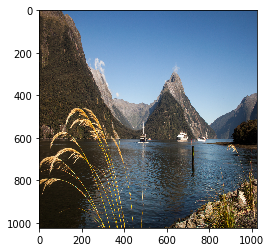

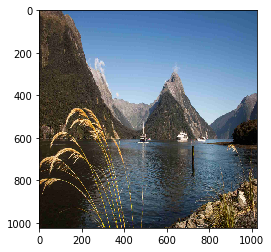

In [73]:
filenames = sorted(os.listdir('DIV2K_train_HR'))

block_size = 32
stride = 16
row_num = (1024 - block_size) // stride + 1
col_num = (1024 - block_size) // stride + 1

img = cv2.resize(cv2.imread('DIV2K_train_HR/'+filenames[38]),(1024,1024))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

compressed_files = sorted(os.listdir('compressed_new'))
test_sample = cv2.resize(cv2.imread('compressed_new/'+compressed_files[38]),(1024,1024))
test_sample = cv2.cvtColor(test_sample, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.figure()
plt.imshow(test_sample)
test_data = []
for y in range(row_num):
    for x in range(col_num):
        x_start = x*stride
        x_end = x_start+block_size
        y_start = y*stride
        y_end = y_start+block_size
        block = test_sample[y_start:y_end, x_start:x_end, :]
        pred_block = loaded_model.predict(block.reshape(1,32,32,3))
        test_data.append(pred_block.astype('uint8'))

len(test_data)

In [74]:
test_data = np.reshape(test_data,(row_num, col_num, 32,32,3))
print(test_data.shape)

(63, 63, 32, 32, 3)


(1024, 1024, 3)


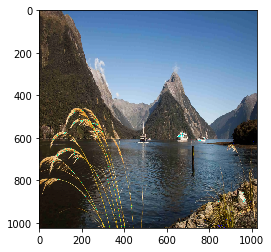

In [75]:
recon = np.ones((img.shape[0],img.shape[1],3))
print(recon.shape)


for i in range(0,row_num):
    for j in range(0,col_num):
        if i%2 == 0 and j%2 == 0:
            recon[i*16:i*16+32,j*16:j*16+32, :] = test_data[i][j].astype('uint8')
            
for i in range(0,row_num):
    for j in range(0,col_num):
        if i%2 != 0 and j%2 != 0:
            recon[i*16:i*16+32,j*16:j*16+32] = (recon[i*16:i*16+32,j*16:j*16+32] + test_data[i][j])/2

recon = recon.astype('uint8')
plt.imshow(recon) 
# print(recon)

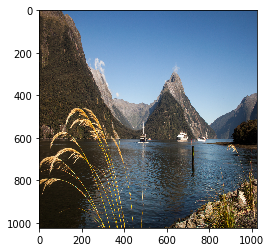

(1024, 1024, 3)
MSE:  85.16253280639648
MSE:  99.01434230804443

MAE (Y, X):  43.07428709665932
MAE (Y , Predict):  35.17765998840331


True

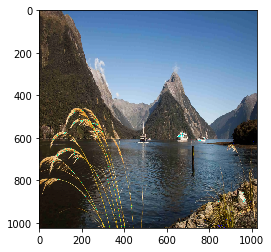

In [76]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# plt.subplot(121)
plt.imshow(img)
plt.show()
# plt.subplot(122)
print(recon.shape)
plt.imshow(recon)
recon = np.array(recon)
err = np.sum((recon.astype("uint8") - img.reshape(img.shape[0],img.shape[1],3).astype("uint8")) ** 2)
err /= float(recon.shape[0] * recon.shape[1])
print("MSE: ",err)
err1 = np.sum((test_sample.astype("uint8") - img.reshape(img.shape[0],img.shape[1],3).astype("uint8")) ** 2)
err1 /= float(recon.shape[0] * recon.shape[1])
print("MSE: ",err1)
# Compute MAE
chan1 = img[:,:,0].reshape(img.shape[0],img.shape[1])
chan2 = img[:,:,1].reshape(img.shape[0],img.shape[1])
chan3 = img[:,:,2].reshape(img.shape[0],img.shape[1])

ts_chan1 = test_sample[:,:,0].reshape(test_sample.shape[0],test_sample.shape[1])
ts_chan2 = test_sample[:,:,1].reshape(test_sample.shape[0],test_sample.shape[1])
ts_chan3 = test_sample[:,:,2].reshape(test_sample.shape[0],test_sample.shape[1])

e1_ = abs(chan1 - ts_chan1)
e2_ = abs(chan2 - ts_chan2)
e3_ = abs(chan3 - ts_chan3)
e_img_ts = np.mean((e1_+e2_+e3_)/3)

r_chan1 = recon[:,:,0].reshape(recon.shape[0],recon.shape[1])
r_chan2 = recon[:,:,1].reshape(recon.shape[0],recon.shape[1])
r_chan3 = recon[:,:,2].reshape(recon.shape[0],recon.shape[1])

e1 = abs(chan1 - r_chan1)
e2 = abs(chan2 - r_chan2)
e3 = abs(chan3 - r_chan3)
e_img_r = np.mean((e1+e2+e3)/3)
# plt.imshow(chan1, cmap = 'gray')
# plt.figure()
# plt.imshow(chan2, cmap = 'gray')
# plt.figure()
# plt.imshow(chan3, cmap = 'gray')
# e1 = 
print('\nMAE (Y, X): ', e_img_ts)
print('MAE (Y , Predict): ', e_img_r)

cv2.imwrite('./predicted/color_label.png',cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
cv2.imwrite('./predicted/color_input.png',cv2.cvtColor(test_sample, cv2.COLOR_RGB2BGR))
cv2.imwrite('./predicted/color_pred.png',cv2.cvtColor(recon, cv2.COLOR_RGB2BGR))

In [77]:
import math
def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

print(psnr(recon, img.reshape(img.shape[0],img.shape[1],3)))
print(psnr(test_sample, img.reshape(img.shape[0],img.shape[1],3)))

33.59953046340729
32.94503508524393


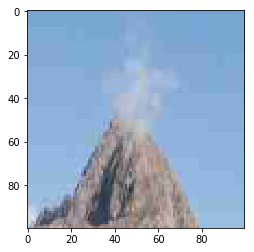

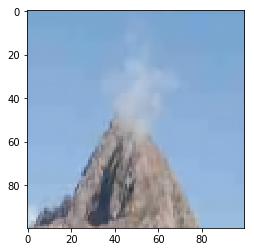

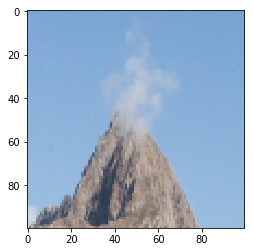

In [86]:
block_size = 100
stride = 16
y = 15
x = 37
x_start = x*stride
x_end = x_start+block_size
y_start = y*stride
y_end = y_start+block_size
input_block = test_sample[y_start:y_end, x_start:x_end, :]
cv2.imwrite('./predicted/color_peak_input_patch.png', cv2.cvtColor(input_block, cv2.COLOR_RGB2BGR))
label_block = img[y_start:y_end, x_start:x_end, :]
cv2.imwrite('./predicted/color_peak_label_patch.png', cv2.cvtColor(label_block, cv2.COLOR_RGB2BGR))
pred_block = recon[y_start:y_end, x_start:x_end, :]
cv2.imwrite('./predicted/color_peak_pred_patch.png', cv2.cvtColor(pred_block, cv2.COLOR_RGB2BGR))

plt.imshow(input_block)
plt.figure()
plt.imshow(pred_block.reshape(block_size,block_size,3))
plt.figure()
plt.imshow(label_block.reshape(block_size,block_size,3))